In [10]:
import pandas as pd
import seaborn as sns 
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('../../code')
import leakage


In [7]:
data_folder = Path('../../data')
figure_folder = Path('../../Figures/')
div_folder = Path('../../../data/this_project/5_div/')


## Get extracellular data

In [111]:
sintef_fn = data_folder / 'this_project/1_e_coli_batch_cultures/1ABE_merged_metabolomics_data.csv'
sintef_od_fn = data_folder / 'this_project/1_e_coli_batch_cultures/1H_OD_and_gDW.csv'

paczia_fn = data_folder / 'paczia_2012' / 'e_coli'/'e_coli_exometabolites.csv'
paczia_od_fn = data_folder / 'paczia_2012' / 'e_coli'/'e_coli_OD.csv'

# vila_fn = data_folder / 'vila_2023' / 'Targeted_LCMS.csv'
# vila_od_fn = data_folder / 'vila_2023' /'Growth_Rates_Fig2.csv'


## Sintef

In [151]:
sintef_df = pd.read_csv(sintef_fn, index_col=0)
# Only intrerested in the absolute quantification
sintef_df = sintef_df.loc[sintef_df['Concentration [uM]'].notna()]

In [152]:
sintef_od = pd.read_csv(sintef_od_fn, index_col = 0)

In [153]:
sintef_od_dict = sintef_od.set_index(['Hours', 'Bioreactor'])['OD'].to_dict()

In [154]:
sintef_od_dict[0, np.nan] = np.nan

In [155]:
sintef_df['OD'] = sintef_df.apply(lambda x: sintef_od_dict[x['Hours'], x['Bioreactor']], axis=1)

#### Delta concentration

In [156]:
sintef_t0 = sintef_df.loc[sintef_df.Hours ==0]
# sintef_conc0_dict = .groupby(['Carbon source', 'Metabolite']).mean('Concentration [uM]')['Concentration [uM]'].to_dict()

In [157]:
def get_delta_concentration(x):
    c = x['Concentration [uM]']
    try:
        c0 = sintef_conc0_dict[x['Carbon source'], x['Metabolite']]
    except KeyError:
        return c
    else:
        return c-c0

In [158]:
sintef_df['Delta concentration [uM]'] = sintef_df.apply(lambda x:get_delta_concentration(x), axis = 1)


In [159]:
sintef_df.loc[sintef_df['Delta concentration [uM]']< 0, 'Delta concentration [uM]'] = np.nan

In [160]:
sintef_df.loc[sintef_df.Timepoint==4, 'Phase'] = 'Stationary'
sintef_df.loc[sintef_df.Timepoint.isin([1,2,3]), 'Phase'] = 'Exponential'

## Paczia

In [62]:
paczia_df, paczia_df_std = leakage.get_concentrations(paczia_fn.parent, 'e_coli')

In [63]:
paczia_df.loc[:2]

,G6P,F6P,FBP,DHAP,GA3P,23PG,PEP,R5P,RU5P+X5P,E4P,...,LEU,TRP,HIS,ARG,PYR,ORO,FUM,URA,AKG,ACT
Time,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.101467,0.446667,0.0,0.190667,0.024512,0.054400,0.0,0.003685,0.0,0.0,...,0.041667,0.031867,4.690000,0.138467,0.00,8.00,13.50,88.50,0.0,444.0
2,0.277733,0.782667,0.0,0.533333,0.009140,0.096667,0.0,0.017333,0.0,0.0,...,0.039967,0.035833,3.856667,0.619000,36.75,15.25,1.25,4.25,0.0,415.0


In [64]:
paczia_df = paczia_df.loc[2:] - paczia_df.loc[1]

In [65]:
paczia_od = pd.read_csv(paczia_od_fn)

In [66]:
paczia_time_to_od = paczia_od.set_index('Time')['OD mean'].to_dict()

In [67]:
paczia_df['2PG'] =  paczia_df['3PG'] = paczia_df['23PG']/2
paczia_df['RU5P'] = paczia_df['X5P'] = paczia_df['RU5P+X5P']/2

In [68]:
paczia_df.drop(columns=['23PG', 'RU5P+X5P'], inplace=True)

In [72]:
paczia_dfL = paczia_df.reset_index().melt(id_vars='Time', var_name='Abbreviation', value_name='Delta concentration [uM]')
paczia_dfL['OD'] = paczia_dfL.Time.map(paczia_time_to_od)

In [73]:
mapping_df = pd.read_csv(data_folder / 'this_project/5_div/5B_id_mapping.csv', index_col=0)
met_abrv_to_id = mapping_df['Ecoli metabolite'].to_dict()
met_abrv_to_name = mapping_df['Metabolite name'].to_dict()
met_name_to_abrv_paczia = {value:key for key, value in met_abrv_to_name.items()}
met_abrv_to_name['SER'] = 'Serine'
met_abrv_to_name['DHAP'] = 'Dihydroxyacetone phosphate'
met_abrv_to_name['2PG'] = '2-phosphoglycerate'
met_abrv_to_name['3PG'] = '3-phosphoglycerate'
met_abrv_to_name['X5P'] = 'Xylulose-5-phosphate'
met_abrv_to_name['RU5P'] = 'Ribulose-5-phosphate'

In [74]:
paczia_dfL['Metabolite'] = paczia_dfL.Abbreviation.map(met_abrv_to_name)

In [75]:
paczia_dfL.loc[paczia_dfL.Time <= 10, 'Phase'] = 'Exponential'
paczia_dfL.loc[paczia_dfL.Time > 10, 'Phase'] = 'Stationary'

In [81]:
paczia_dfL.loc[paczia_dfL['Delta concentration [uM]'] < 0, 'Delta concentration [uM]'] = np.nan

## Vila
Don't have OD data for E. coli

In [89]:
# vila_df = pd.read_csv(vila_fn)
# vila_df = vila_df.loc[vila_df.Strain == 'Ecoli']
# metname_translate_dict = {'Acetic acid': 'Acetate',
# 'Acetyl-ornithine': 'Acetyl-ornithine',
# 'Alanine': 'Alanine',
# 'Asparagine': 'Asparagine',
# 'Butyric acid': 'Butyrate',
# 'Citric acid': 'Citrate',
# 'Fumaric acid': 'Fumarate',
# 'Glycine': 'Glycine',
# 'Lactic acid': 'Lactate',
# 'Methionine': 'Methionine',
# 'Propionic acid': 'Propionate',
# 'Putrescine': 'Putrescine',
# 'Pyruvic acid': 'Pyruvate',
# 'Serine': 'Serine',
# 'Succinic acid': 'Succinate',
# 'Valeric acid':'Valerate',
# 'Valine': 'Valine',
# 'alpha-Ketoglutaric acid': 'Alpha-ketoglutarate',
# 'beta-Hydroxybutyric acid': 'Beta-hydroxybutyrate'}
# vila_df['Metabolite'] = vila_df.Metabolite.map(metname_translate_dict)

In [90]:
# vila_df['Delta concentration [uM]'] = vila_df.Metabolite_Conc
# # vila_df.loc[vila_df.Metabolite_Conc==0, 'Delta concentration [uM]'] = np.nan

In [85]:
# vila_od_df = pd.read_csv(vila_od_fn)

## Join dataframes

In [167]:
paczia_dfL['Hours'] = paczia_dfL['Time']
paczia_dfL['Carbon source'] = 'Glucose'

In [168]:
df_ex = pd.concat([sintef_df, paczia_dfL])[['Hours', 'Delta concentration [uM]', 'OD', 'Phase', 'Metabolite', 'Carbon source']]

In [170]:
df_ex = df_ex.loc[~df_ex.isna().any(axis=1)]

In [171]:
df_ex

,Hours,Delta concentration [uM],OD,Phase,Metabolite,Carbon source
810,10.0,0.017935,2.19,Exponential,Alpha-aminoadipate,L-malate
811,16.0,0.104060,0.89,Exponential,Alpha-aminoadipate,L-alanine
812,12.0,0.035617,2.57,Stationary,Alpha-aminoadipate,L-malate
817,14.0,0.076829,2.89,Exponential,Alpha-aminoadipate,Galactose
820,12.0,0.014934,1.63,Exponential,Alpha-aminoadipate,Galactose
...,...,...,...,...,...,...
658,14.0,1.587333,15.34,Stationary,Xylulose-5-phosphate,Glucose
659,15.0,1.516667,14.43,Stationary,Xylulose-5-phosphate,Glucose
660,16.0,1.392000,14.21,Stationary,Xylulose-5-phosphate,Glucose
661,17.0,1.338000,13.61,Stationary,Xylulose-5-phosphate,Glucose


## Get intracellular literature data

In [173]:
conditions_fn = data_folder / 'this_project/4_paired_metabolomics_live_dead/4F_mapped_intracellular_conc.csv'
conditions_df = pd.read_csv(conditions_fn, index_col=0)

In [174]:
conditions_df

,Carbon source,Phase,Metabolite,Intracellular concentration [uM],Error [uM],SEM [uM],# values,idx concentration sheet,Min,Max,LB,Min LB,UB,Max UB
0,L-malate,Stationary,Alanine,358.000000,0.000000,0.000000,1.0,15,358.000000,358.0,358.000000,358.000000,358.000000,358.0
1,L-malate,Exponential,Alanine,1197.900000,825.752376,421.302233,5.0,"18,16,10,13,14",349.166667,2550.0,372.147624,240.523917,2023.652376,2800.0
2,L-malate,Stationary,Alpha-aminoadipate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,L-malate,Exponential,Alpha-aminoadipate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,L-malate,Stationary,Asparagine,103.000000,0.000000,0.000000,1.0,35,103.000000,103.0,103.000000,103.000000,103.000000,103.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693,Pyruvate,Unknown,Alpha-ketoglutarate,352.946667,188.770993,96.311731,5.0,"23,24,22,21,20",126.400000,616.0,164.175674,105.805072,541.717659,1060.0
694,Pyruvate,Unknown,Alpha-ketoglutarate,352.946667,188.770993,96.311731,5.0,"23,24,22,21,20",126.400000,616.0,164.175674,105.805072,541.717659,1060.0
695,Pyruvate,Unknown,Beta-hydroxybutyrate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
696,Pyruvate,Unknown,Beta-hydroxybutyrate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Merge intracellular and extracellular

In [186]:
df = pd.merge(left = df_ex, right = conditions_df, left_on=['Metabolite', 'Carbon source', 'Phase'], 
              right_on=['Metabolite', 'Carbon source', 'Phase'], how = 'left')


In [187]:
df = df.loc[df['Intracellular concentration [uM]'].notna()].copy()

In [188]:
total_cell_volume_per_od = 3.6 # uL per OD per mL Total cell volume conversion, see Volkmer and Heinemann 2011, https://pmc.ncbi.nlm.nih.gov/articles/PMC3146540/


In [191]:
# 1e-6 to convert from uL to L and 1e3 to convert from ml to L
df['Corresponding Ex. concentration [uM]']= total_cell_volume_per_od*df['OD']*1e-6*df['Intracellular concentration [uM]']*1e3


In [205]:
df['Fraction of cells needed'] = df['Delta concentration [uM]']/df['Corresponding Ex. concentration [uM]']

In [239]:
df = df.loc[df['Delta concentration [uM]']>0]

In [240]:
df.sort_values(by = 'Metabolite', inplace=True)

/var/folders/xf/kl76knj11y72v0_qy4vv7tgh0000gp/T/ipykernel_11305/3631046826.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by = 'Metabolite', inplace=True)


In [241]:
df['Fraction of cells needed'].sort_values()

264       0.000368
586       0.000765
950       0.000883
465       0.001499
600       0.001527
          ...     
674    1690.681884
673    1827.877605
678    3621.586976
676    3807.443973
677    4165.321700
Name: Fraction of cells needed, Length: 1131, dtype: float64

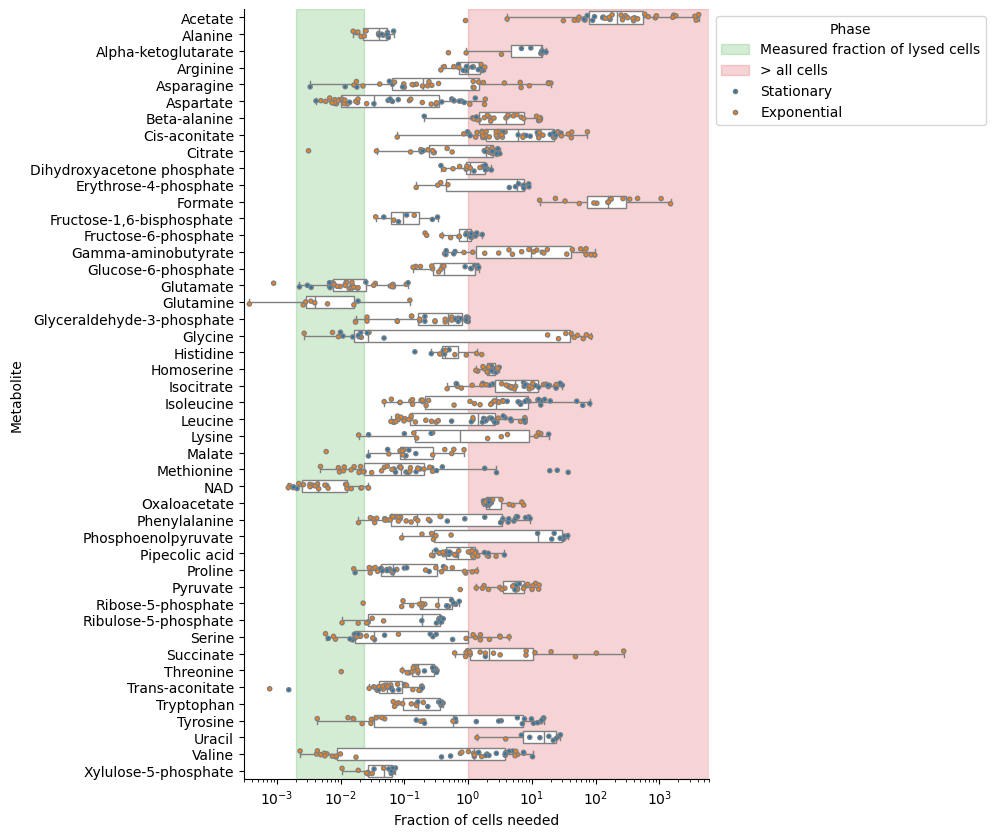

In [318]:
fig, ax = plt.subplots(1, figsize = (6, 10))
ax.set_xscale('log')

ax.axvspan(0.002, 0.023, color = 'C2', alpha = 0.2, label = 'Measured fraction of lysed cells', zorder = 0)
ax.axvspan(1, 5e4, color = 'C3', alpha = 0.2, label = '> all cells', zorder = 0)
l = sns.boxplot(df, x = 'Fraction of cells needed', y = 'Metabolite', fill=True,gap=.1,
                ax = ax, legend = None, color = 'w',fliersize = 0, linecolor = 'grey')
sns.stripplot(data = df, x = 'Fraction of cells needed', y = 'Metabolite', ax = ax, edgecolor = 'grey', linewidth = 1, size=3, jitter=0.2, hue = 'Phase')#, color = 'C0')
ax.set_xlim(3e-4, 6e3)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
sns.despine()

(0.0003, 6000.0)

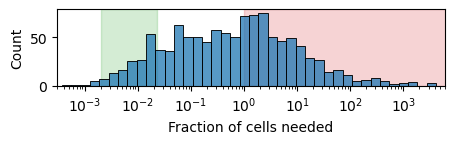

In [306]:
fig, ax = plt.subplots(1, figsize = (5, 1))
sns.histplot(data = df, x = 'Fraction of cells needed', log_scale=True, bins = 40, ax = ax)
ax.axvspan(0.002, 0.023, color = 'C2', alpha = 0.2, label = 'Measured ratio of dead cells', zorder = 0)
ax.axvspan(1, 5e4, color = 'C3', alpha = 0.2, label = 'Infeasible', zorder = 0)
ax.set_xlim(3e-4, 6e3)


In [315]:
(df['Fraction of cells needed']<0.023).sum()

np.int64(154)

In [314]:
(df['Fraction of cells needed']<0.023).sum()/len(df['Fraction of cells needed'])

np.float64(0.1361626878868258)

In [317]:
(df['Fraction of cells needed']>1).sum(), (df['Fraction of cells needed']>1).sum()/len(df['Fraction of cells needed'])

(np.int64(506), np.float64(0.4473916887709991))

In [313]:
977+154

1131

1131